# Week 3 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git
#from lucem_illud_2020 import cartoons
#from lucem_illud_2020 import proccessing
# import lucem_illud_2020.proccessing
# import lucem_illud_2020.cartoons
# import lucem_illud_2020.metrics
# import lucem_illud_2020.loaders

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [2]:
noise = .2

#dftrain, dftest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

In [3]:
dfTrain

,vect,category
128,"[0.6896355132210754, -1.1073793742311524]",0
398,"[-0.5079542306931403, 0.3360368339090881]",0
215,"[0.6078824986978448, 0.5924492266652032]",1
738,"[0.2658758068049799, -0.35323880558352977]",0
481,"[-0.16631102717503177, 0.1507884465763213]",1
161,"[-0.7111356629307788, -0.353561420382393]",1
953,"[0.14735968146061867, 0.22759037078227795]",1
322,"[-0.46808309264807, -0.20618882932006183]",0
294,"[0.29569141597816245, -0.9787879209670146]",0
917,"[0.38777045603232585, 0.7203654247864205]",1


In [4]:
dfTrain2, dfTest2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


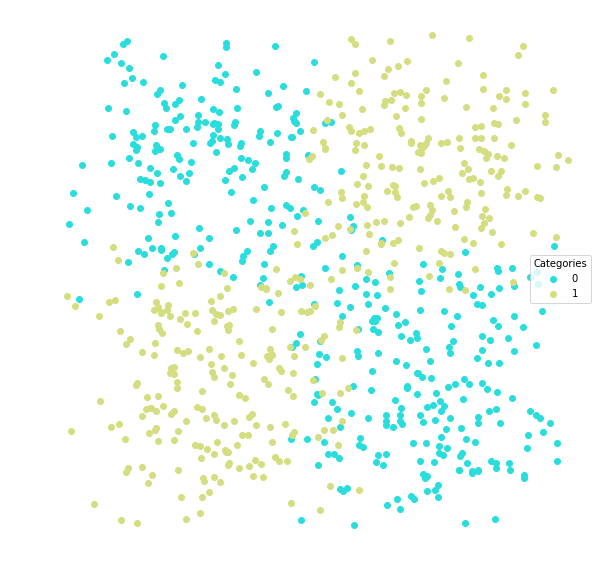

In [5]:
lucem_illud_2020.plotter(dfTrain)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


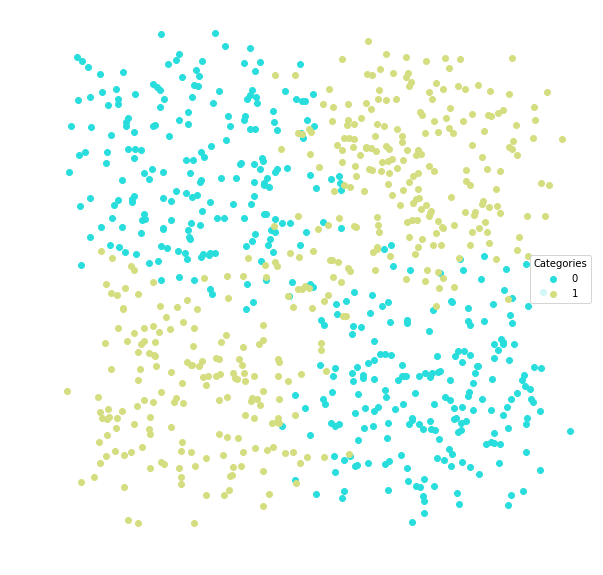

In [6]:
lucem_illud_2020.plotter(dfTrain2)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [7]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [8]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [9]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.135,0.864936,0.867347,0.814692,0.858586
1,0.135,0.864936,0.862745,0.816699,0.871287


This lets us look at which classes do better:

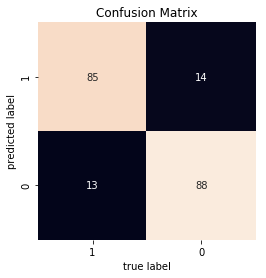

In [10]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

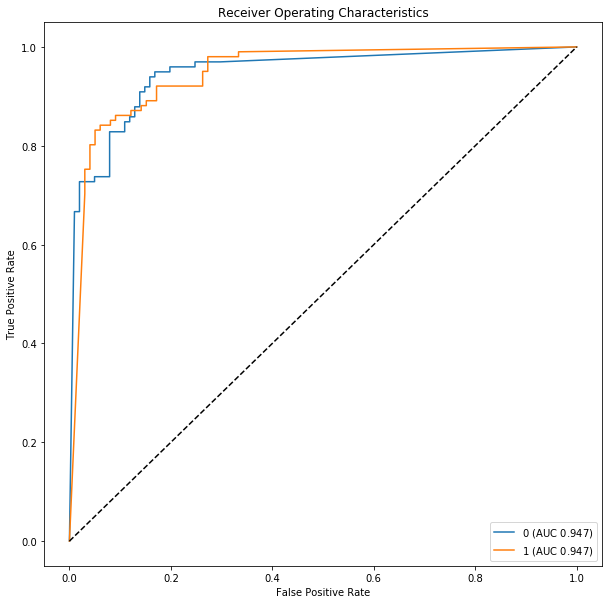

In [11]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


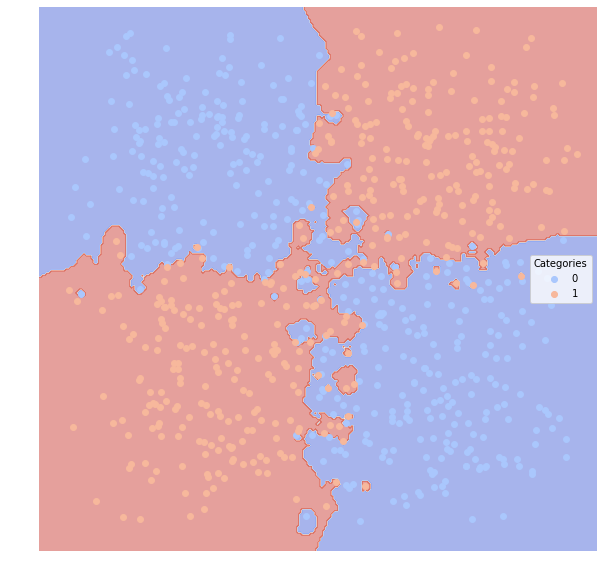

In [12]:
lucem_illud_2020.metrics.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [13]:
dfTrain, dfTest = lucem_illud_2020.proccessing.trainTestSplit(lucem_illud_2020.loaders.loadReddit())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading Reddit data
Converting to vectors


In [14]:
dfTrain.head()

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,category,tokenized_text,normalized_text,vect
673,673,johnnydill50000,False,36,Bad Roommates: Tales of Irritation,"My roommate she doesn't have a meal plan, she'...","My roommate, she is a broke bitch HELP me!!!",https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[My, roommate, she, does, n't, have, a, meal, ...","[roommate, meal, plan, broke, ask, food, oh, r...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1000,1000,SukhoiZero,False,149,Weeaboo Tales: stories about the extreme fans ...,"I heard this sub needed more stories, so I wil...",How High School Japanese Class and the Library...,https://www.reddit.com/r/weeabootales/comments...,Weeaboo Tales,"[I, heard, this, sub, needed, more, stories, s...","[hear, sub, need, story, tell, anime, aspect, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
724,724,rabbledabbled,False,35,Bad Roommates: Tales of Irritation,Original post: http://www.reddit.com/r/badroo...,Update: My roommate has issues.,https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[Original, post, http://www.reddit.com/r/badro...","[original, post, http://www.reddit.com/r/badro...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
938,938,CandyKhorne,False,171,Weeaboo Tales: stories about the extreme fans ...,"be me, CandyKhorne, Born in a western country....",Tales of 'Kawaii' Girl: Awkward sushi time,https://www.reddit.com/r/weeabootales/comments...,Weeaboo Tales,"[be, me, CandyKhorne, Born, in, a, western, co...","[candykhorne, bear, western, country, despite,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
640,640,darlingliteral,False,38,Bad Roommates: Tales of Irritation,I [F23] live with two other women [F24] & [F25...,I don't know how to live with these people any...,https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[I, F23, live, with, two, other, women, F24, F...","[f23, live, woman, f24, f25, casual, friend, m...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [15]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [16]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB(priors=None, var_smoothing=1e-09)

In [17]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.059561,0.908073,0.920000,0.814899,0.841463
Weeaboo Tales,0.166144,0.872861,0.595041,0.576263,0.947368
Bad Roommates,0.122257,0.827547,0.789474,0.642804,0.722892
Relationships,0.191223,0.674008,0.680851,0.423524,0.410256


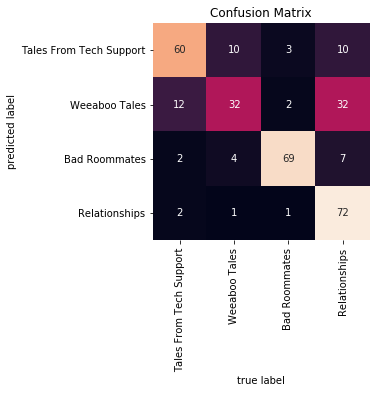

In [18]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

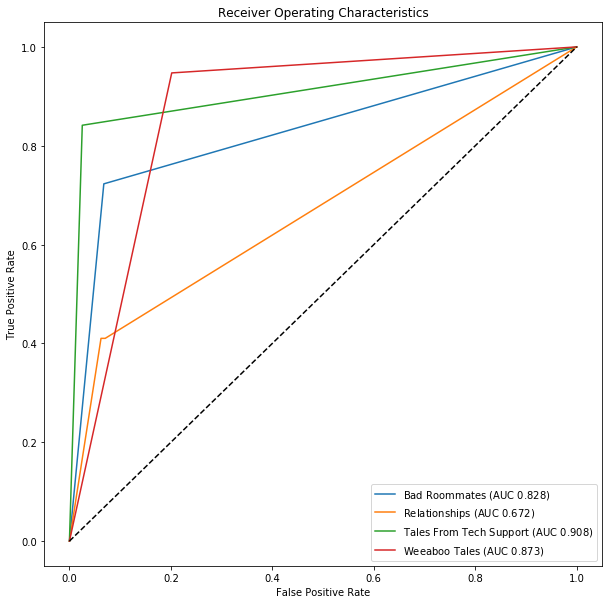

In [19]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

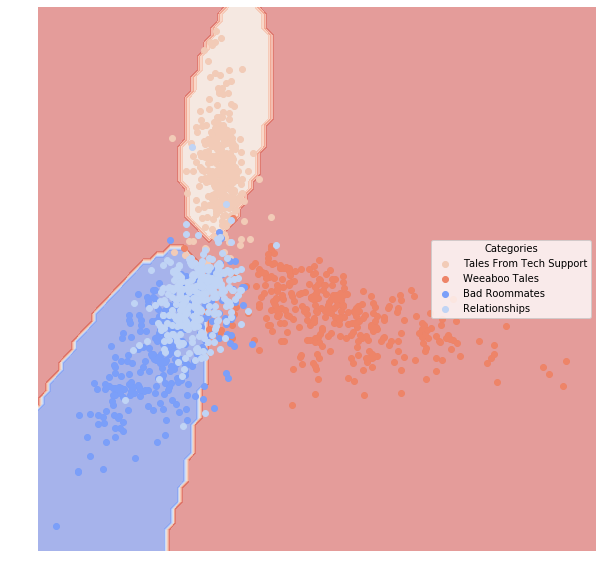

In [20]:
lucem_illud_2020.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [102]:
def gen_dataset(i, noise):
    if i == 5:
        dfTrain, dfTest = lucem_illud_2020.trainTestSplit(
            lucem_illud_2020.multiBlobs(noise))
    elif i % 5 == 0:
        dfTrain, dfTest = lucem_illud_2020.trainTestSplit(
            lucem_illud_2020.random())
    elif i % 5 == 1:
        dfTrain, dfTest = lucem_illud_2020.trainTestSplit(
            lucem_illud_2020.andSplit(noise))
    elif i % 5 == 2:
        dfTrain, dfTest = lucem_illud_2020.trainTestSplit(
            lucem_illud_2020.xorSplit(noise))
    elif i % 5 == 3:
        dfTrain, dfTest = lucem_illud_2020.trainTestSplit(
            lucem_illud_2020.targetSplit(noise))
    elif i % 5 == 4:
        dfTrain, dfTest = lucem_illud_2020.trainTestSplit(
            lucem_illud_2020.multiBlobs(noise))

    return dfTrain, dfTest

In [98]:
def fit_models(dfTrain):
    models = []
    
    #Bayes
    clf = sklearn.naive_bayes.GaussianNB()
    clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    models.append(clf)

    #Analogizes
    clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
    clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    models.append(clf)

    clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
    clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    models.append(clf)

    #Nearest Neighbors
    clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'
    clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    models.append(clf)

    #Classical Regression
    clf = sklearn.linear_model.LogisticRegression()
    clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    models.append(clf) 
    
    #Symbolists
    clf = sklearn.tree.DecisionTreeClassifier()
    clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    models.append(clf)

    clf = sklearn.ensemble.RandomForestClassifier()
    clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    models.append(clf)

    #Connectionists
    clf = sklearn.neural_network.MLPClassifier()
    clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    models.append(clf)

    #Ensemble
    clf = sklearn.ensemble.GradientBoostingClassifier()
    clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    models.append(clf)

    return models

In [124]:
# Test on 1 toy data set
train_df, test_df = gen_dataset(0, 0.1)
models = fit_models(train_df)
results = lucem_illud_2020.compareModels(train_df, test_df, models)
results[['Error_Rate']].idxmin()
#results[['Error_Rate']].min()['Error_Rate']

Error_Rate    MLPClassifier
dtype: object

In [111]:
results

,Error_Rate,AUC-0,AUC-1
Model,,,
GaussianNB,0.465,0.535,0.535
SVC,0.490,0.510,0.510
SVC,0.480,0.520,0.520
KNeighborsClassifier,0.550,0.450,0.450
LogisticRegression,0.485,0.515,0.515
DecisionTreeClassifier,0.530,0.470,0.470
RandomForestClassifier,0.505,0.495,0.495
MLPClassifier,0.545,0.455,0.455
GradientBoostingClassifier,0.485,0.515,0.515


In [365]:
# generate 10 distinct datasets varying at 2 levels of noise (0.3 and 0.6)
noise_levels = [0.3] * 10
noise_levels[0] = 0
for i in range(5, 10):
    noise_levels[i] = 0.6
noise_levels[-1] = 0.9
noise_levels

[0, 0.3, 0.3, 0.3, 0.3, 0.6, 0.6, 0.6, 0.6, 0.9]

In [366]:
def report(i, noise, results):
    if (i == 5) or (i % 5 == 4):
        func_name = 'multiBlobs'
    elif i % 5 == 0:
        func_name = 'random'
    elif i % 5 == 1:
        func_name = 'andSplit'
    elif i % 5 == 2:
        func_name = 'xorSplit'
    elif i % 5 == 3:
        func_name = 'targetSplit'

    print("For a dataset generated by {} with noise level {}".format(func_name, noise))
    print("The best performing model is {}".format(
        results[['Error_Rate']].idxmin()['Error_Rate']))
    print("Based on the lowest error rate: {0:.3f}\n".format(
        results[['Error_Rate']].min()['Error_Rate']))

In [367]:
def simulate(noise_levels):
    for i, noise in enumerate(noise_levels):
        train_df, test_df = gen_dataset(i, noise)
        models = fit_models(train_df)
        results = lucem_illud_2020.compareModels(train_df, test_df, models)
        report(i, noise, results)

In [368]:
simulate(noise_levels)

For a dataset generated by random with noise level 0
The best performing model is DecisionTreeClassifier
Based on the lowest error rate: 0.465

For a dataset generated by andSplit with noise level 0.3
The best performing model is SVC
Based on the lowest error rate: 0.135



/Users/sanittawan/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/sanittawan/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


For a dataset generated by xorSplit with noise level 0.3
The best performing model is GradientBoostingClassifier
Based on the lowest error rate: 0.160



/Users/sanittawan/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/sanittawan/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


For a dataset generated by targetSplit with noise level 0.3
The best performing model is MLPClassifier
Based on the lowest error rate: 0.150

For a dataset generated by multiBlobs with noise level 0.3
The best performing model is MLPClassifier
Based on the lowest error rate: 0.124



/Users/sanittawan/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


For a dataset generated by multiBlobs with noise level 0.6
The best performing model is SVC
Based on the lowest error rate: 0.030

For a dataset generated by andSplit with noise level 0.6
The best performing model is DecisionTreeClassifier
Based on the lowest error rate: 0.310



/Users/sanittawan/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


For a dataset generated by xorSplit with noise level 0.6
The best performing model is GradientBoostingClassifier
Based on the lowest error rate: 0.250



/Users/sanittawan/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/sanittawan/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


For a dataset generated by targetSplit with noise level 0.6
The best performing model is MLPClassifier
Based on the lowest error rate: 0.290

For a dataset generated by multiBlobs with noise level 0.9
The best performing model is GaussianNB
Based on the lowest error rate: 0.054



1. **Random** - since the data is random, it is not surprising that a high variance and very flexible model like decision tree would perform best.
2. **andSplit** - from the results above with varying noise level, we found that the best performing models also change. For level 0.3, SVC performs best while, for level 0.6, decision tree performs best. Increasing the noise level makes it easier for more flexible models like decision tree to perform better.
3. **xorSplit** - for this particular data, we found that gradient boosting classifier consistently performs best at both noise level. I think this is because the xorsplit has a complicated decision boundary, so boosting algorithm which is quite flexible would perform best.
4. **targetSplit** - for target split, we also found that the neural network classifier consistently performs best among other models. I think this is because it is able to draw a boundary line in higher dimension that split two classes effectively since the classes are nested in 2 dimensions.
5. **multiblobs** - there is no consistent best performing model for this kind of data. Neural network, SVC, and Naive Bayes were selected at varying levels of noise.  

In [138]:
def gen_real_dataset(i):
    if i % 5 == 0:
        dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
    elif i % 5 == 1:
        dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
    elif i % 5 == 2:
        dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
    elif i % 5 == 3:
        dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
    elif i % 5 == 4:
        dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

    return dfTrain, dfTest

In [139]:
def report_real(i, results):
    if i % 5 == 4:
        data_name = 'Spam'
    elif i % 5 == 0:
        data_name = 'Reddit'
    elif i % 5 == 1:
        data_name = 'NewsGroups'
    elif i % 5 == 2:
        data_name = 'SenateSmall'
    elif i % 5 == 3:
        data_name = 'SenateLarge'

    print("For the {} dataset".format(data_name))
    print("The best performing model is {}".format(
        results[['Error_Rate']].idxmin()['Error_Rate']))
    print("Based on the lowest error rate: {0:.3f}\n".format(
        results[['Error_Rate']].min()['Error_Rate']))

In [141]:
def simulate_real():
    for i in range(5):
        train_df, test_df = gen_real_dataset(i)
        models = fit_models(train_df)
        results = lucem_illud_2020.compareModels(train_df, test_df, models)
        report_real(i, results)

In [142]:
simulate_real()

Loading Reddit data
Converting to vectors
For the Reddit dataset
The best performing model is SVC
Based on the lowest error rate: 0.016

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
For the NewsGroups dataset
The best performing model is MLPClassifier
Based on the lowest error rate: 0.096

Loading senate data
Converting to vectors
For the SenateSmall dataset
The best performing model is DecisionTreeClassifier
Based on the lowest error rate: 0.003

Loading senator: Klobuchar
Loading senator: Kyl
Loading senator: Kerry
Loading senator: Kohl
Loading senator: Kennedy
Converting to vectors
For the SenateLarge dataset
The best performing model is DecisionTreeClassifier
Based on the lowest error rate: 0.001

Loading Spam
Loading Ham
Converting to vectors
For the Spam dataset
The best performing model is SVC
Based on the lowest error rate: 0.083



1. **Reddit** - The model that performs best is support vector classification.

2. **News Group** - The model that performs best is neural network.

3. **Small Senate Data** - The model that performs best is a decision tree. 

4. **Large Senate Data** - The model that performs best is also a decision tree. 

5. **Spam** - The model that performs best is support vector classification.

3 methods that seem to work well with these datasets are support vector classification, neural network, and decision tree. It seems that a more flexible (like decision tree) and complicated (like neural network) methods perform much better than other models like logistic regression. What is quite surprising is the boosting model did not perform as well as other methods. To improve the pipeline, cross validation should be used, so that we can average the error rates across many splits of the same dataset.

__New classifier (AdaBoost)__

**Toy dataset**

In [144]:
train_df, test_df = gen_dataset(4, 0.2) #multiblob with noise level = 0.2

In [145]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier() # call with all default params
ada_clf.fit(np.stack(train_df['vect'], axis=0), train_df['category'])
lucem_illud_2020.evaluateClassifier(ada_clf, test_df)

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.226,0.500000,0.000000,0.226000,0.000000
1,0.202,0.502500,0.333333,0.201333,0.010000
2,0.228,0.860294,0.446602,0.446602,1.000000
3,0.002,0.995192,1.000000,0.992385,0.990385
4,0.202,0.867984,0.473404,0.467000,0.978022


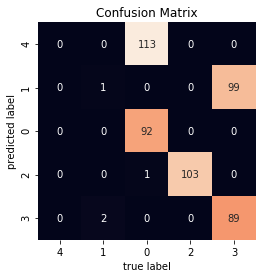

In [146]:
lucem_illud_2020.plotConfusionMatrix(ada_clf, test_df)

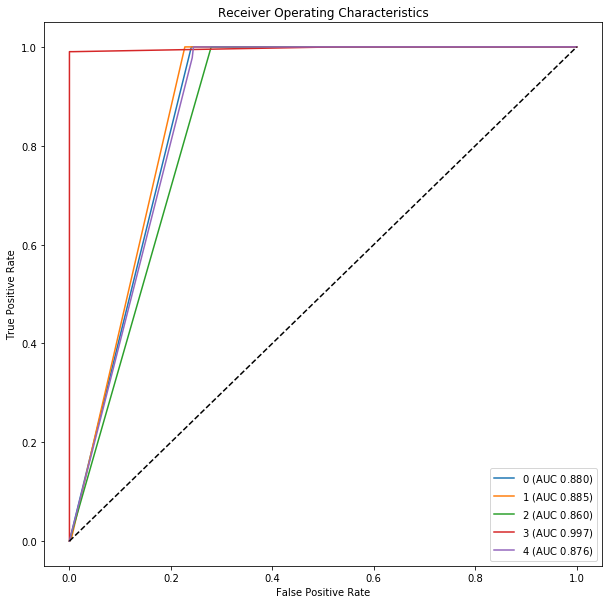

In [147]:
lucem_illud_2020.plotMultiROC(ada_clf, test_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

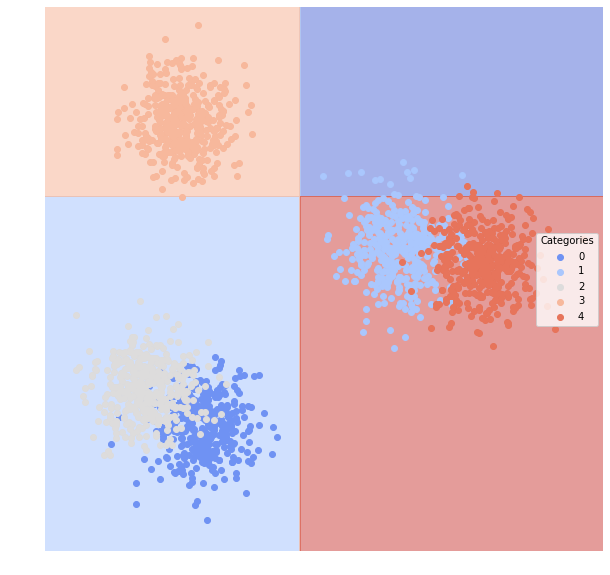

In [148]:
lucem_illud_2020.plotregions(ada_clf, train_df)

**Real dataset (Reddit)**

In [149]:
rtrain_df, rtest_df = gen_real_dataset(0)

Loading Reddit data
Converting to vectors


In [150]:
rada_clf = AdaBoostClassifier() # call with all default params
rada_clf.fit(np.stack(rtrain_df['vect'], axis=0), rtrain_df['category'])
lucem_illud_2020.evaluateClassifier(rada_clf, rtest_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.059561,0.945598,0.861111,0.838141,0.958763
Weeaboo Tales,0.018809,0.977682,0.944444,0.923730,0.971429
Bad Roommates,0.059561,0.878058,0.946429,0.777124,0.768116
Relationships,0.043887,0.943001,0.915663,0.860382,0.915663


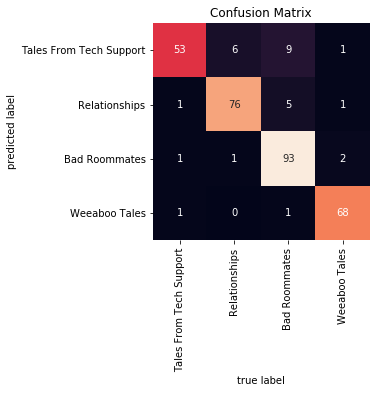

In [151]:
lucem_illud_2020.plotConfusionMatrix(rada_clf, rtest_df)

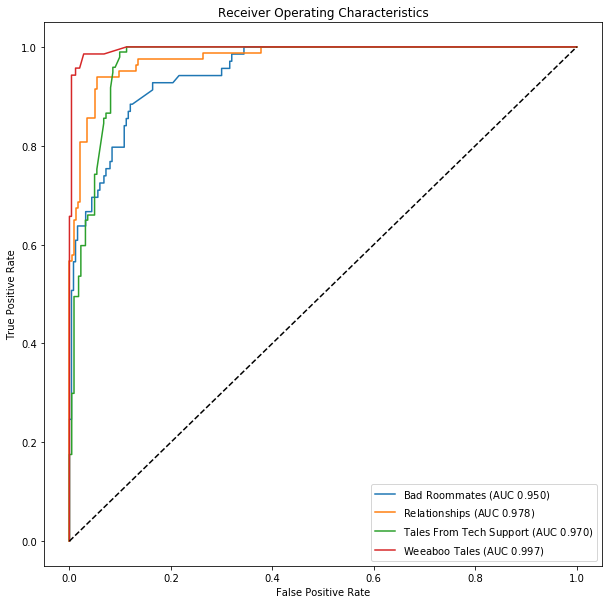

In [152]:
lucem_illud_2020.plotMultiROC(rada_clf, rtest_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

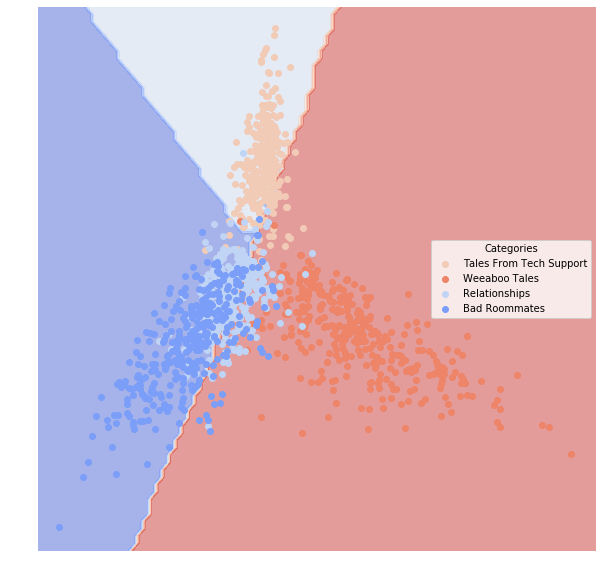

In [153]:
lucem_illud_2020.plotregions(rada_clf, rtrain_df)

__Discussion:__ The Adaboost method performs relatively well compared to other models we ran. Compared to the naive bayes in the example, the adaboost performs better since the AUC is larger. 

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [253]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

Let's turn the 'targetSenator' column into a binary category variable.

In [254]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [255]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

Let's split the data into training data and testing data.

In [256]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [257]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

In [26]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [27]:
TFVects.shape

(1368, 11179)

We can save this in the dataframe to make things easier

In [28]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [29]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [30]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


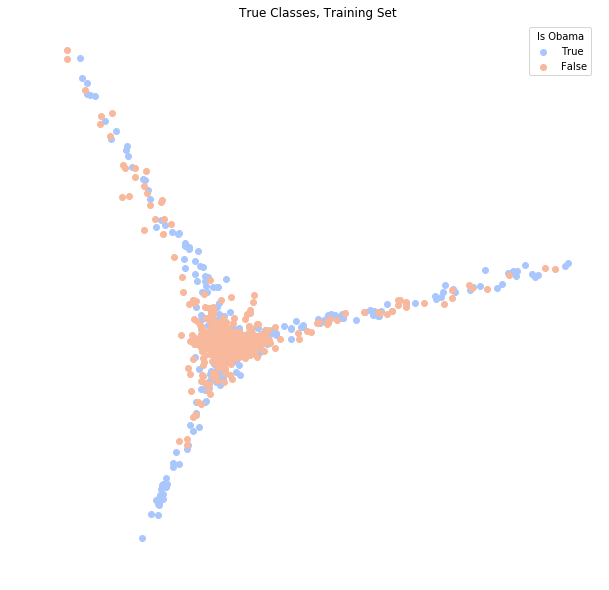

In [31]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

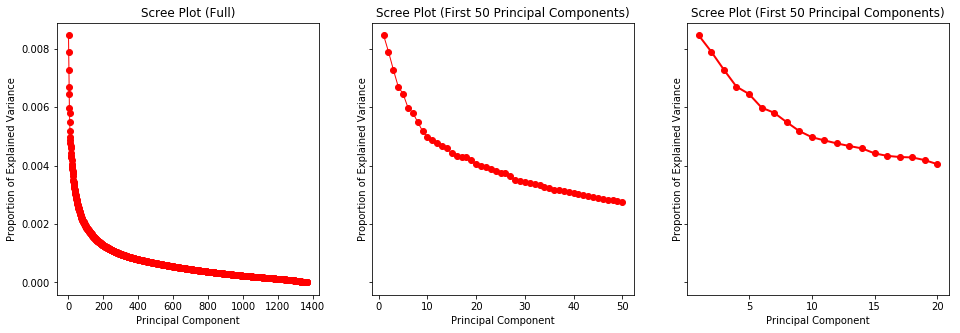

In [32]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [33]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [34]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [35]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6505847953216374

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [36]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6774193548387096

Slightly poorer. How about using more dimensions (40)?

In [37]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.72953216374269
Testing:
0.7302052785923754


Or still more (100)?

In [38]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8245614035087719
Testing:
0.8093841642228738


Or even more (200)!

In [39]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8757309941520468
Testing:
0.8504398826979472


This is becoming ridiculous (400)!

In [40]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9166666666666666
Testing:
0.8651026392961877


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [41]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9568713450292398


Train the model using training data, and then test it on the testing data.

In [42]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8651026392961877


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [43]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [44]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9671052631578947
Testing:
0.8914956011730205


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [45]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [46]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.841726618705036

Recall:

In [47]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.8863636363636364

F1-measure:

In [48]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.8634686346863468

Let's take a look at how well our posterior distribution looks relative to the truth.

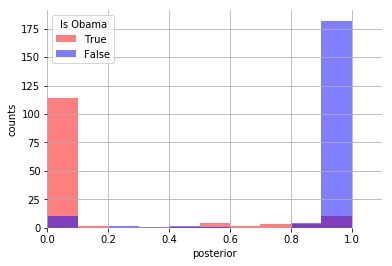

In [49]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [50]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Obama,Obama_log_prob,Clinton,Clinton_log_prob
0,yorkers,-2.079442,5566,-1.734018
1,welcomed,-2.277892,dick,-1.764172
2,island,-2.302585,brundage,-1.860503
3,urging,-2.327903,chicago,-1.967112
4,honor,-2.367124,political,-2.238265
5,ground,-2.380547,reform,-2.238265
6,urged,-2.394152,temporary,-2.238265
7,class,-2.421932,don,-2.271602
8,read,-2.421932,location,-2.271602
9,entire,-2.436116,interests,-2.288696


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [51]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [52]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [53]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [54]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [55]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [56]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [57]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [58]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.8903076030179918


In [59]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
1793,comp.graphics,comp.graphics
2114,comp.graphics,comp.graphics
1538,sci.space,sci.space
2030,comp.graphics,comp.graphics
987,sci.space,sci.space
575,soc.religion.christian,soc.religion.christian
361,talk.religion.misc,soc.religion.christian
1517,sci.space,soc.religion.christian
199,talk.religion.misc,soc.religion.christian
1833,comp.graphics,soc.religion.christian


Looks pretty good, lets examine the testing dataset:

In [60]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.7581395348837209


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

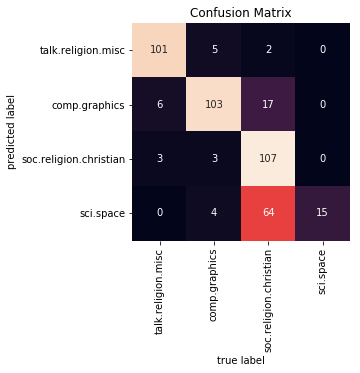

In [61]:
lucem_illud_2020.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [62]:
print(sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall
print(sklearn.metrics.f1_scoretest_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #F-1 measure

0.8825596620385573
0.7581395348837209
0.7883921315532959


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [63]:
lucem_illud_2020.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
soc.religion.christian,0.206977,0.842537,0.563158,0.547209,0.946903
sci.space,0.081395,0.888993,0.895652,0.785648,0.817460
comp.graphics,0.037209,0.953617,0.918182,0.874949,0.935185
talk.religion.misc,0.158140,0.590361,1.000000,0.338862,0.180723


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

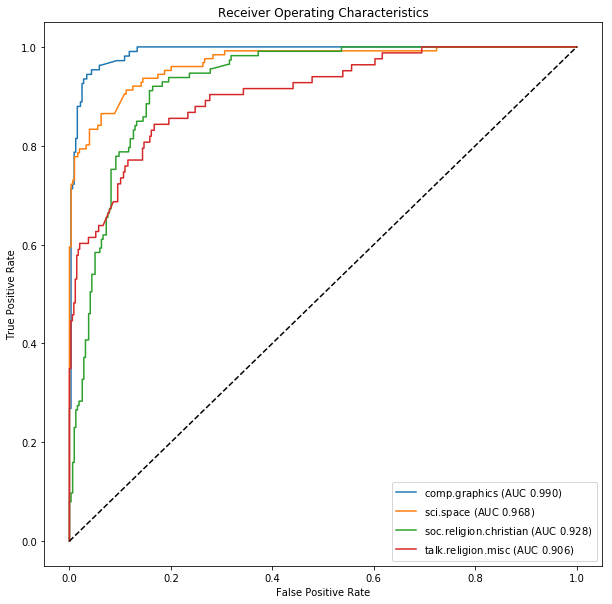

In [64]:
lucem_illud_2020.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

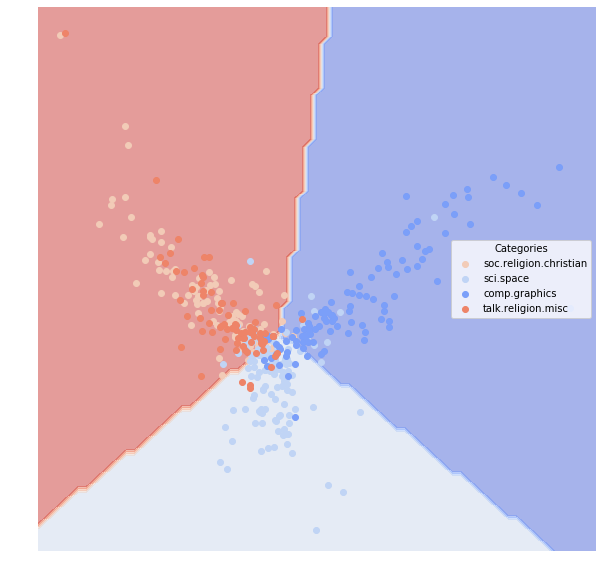

In [65]:
lucem_illud_2020.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


Data is from: https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics/data

Prepare data by randomly selecting 500 songs from the pop and rock categories (totaling 1,000 songs).

In [7]:
lyrics = pandas.read_csv("./data/lyrics.csv")
lyrics.dropna(inplace=True)

In [8]:
lyrics.shape

(266556, 6)

In [9]:
lyrics.columns

Index(['index', 'song', 'year', 'artist', 'genre', 'lyrics'], dtype='object')

In [10]:
lyrics.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [11]:
lyrics['genre'].unique()

array(['Pop', 'Hip-Hop', 'Not Available', 'Rock', 'Metal', 'Other',
       'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie'],
      dtype=object)

In [12]:
lyrics.groupby('genre').size()

genre
Country           14387
Electronic         7966
Folk               2243
Hip-Hop           24850
Indie              3149
Jazz               7970
Metal             23759
Not Available     23941
Other              5189
Pop               40466
R&B                3401
Rock             109235
dtype: int64

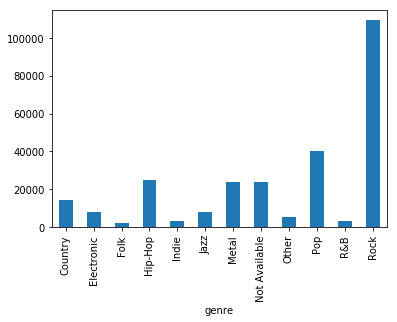

In [13]:
lyrics.groupby('genre').size().plot.bar();

In [14]:
size = 500        # sample size
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
sampled_lyrics = lyrics.groupby('genre', as_index=False).apply(fn)

In [15]:
sampled_lyrics.reset_index(drop=True, inplace=True)
sampled_lyrics.rename(columns={'genre': 'category', 'lyrics': 'text'}, inplace=True)
sampled_lyrics.head()

,index,song,year,artist,category,text
0,146329,her-life-s-a-song,2012,alan-jackson,Country,"She loves the music, tells the tales of her he..."
1,347345,little-sister,1987,dwight-yoakam,Country,"Little sister don't you, little sister don't y..."
2,196412,midnight-sun,2007,garth-brooks,Country,Ain't no hay left on the ground\nGonna join th...
3,57745,singing-my-song,2007,billie-jo-spears,Country,Here's a song I love to sing it's about the ma...
4,325836,the-lady-is-dancing-with-me,2006,chris-ledoux,Country,I was waltzin' with my darlin' at the cattlema...


In [16]:
# need filter the dataset
two_genres = ['Pop', 'Rock']
four_genres = ['Hip-Hop', 'Metal', 'Pop', 'Rock']
two_genre_df = sampled_lyrics[sampled_lyrics.category.isin(two_genres)]
four_genre_df = sampled_lyrics[sampled_lyrics.category.isin(four_genres)]

In [17]:
two_genre_df = lucem_illud_2020.generateVecs(two_genre_df)

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/lucem_illud_2020/loaders.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(x))
/Users/sanittawan/anaconda3/lib/python3.6/site-packages/lucem_illud_2020/loaders.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['normalized_text'] = df['tokenized_text'].apply(lambda x: normalizeTokens(x))
/Users/sanittawan/anaconda3/lib/python3.6/site-packages/lucem_illud_2020/loaders.py:79: SettingWithCopyWarning: 
A value is tryin

In [18]:
four_genre_df = lucem_illud_2020.generateVecs(four_genre_df)

In [19]:
two_genre_df['category'] = two_genre_df['category'].astype('category')

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
import numpy as np
two_genre_df['bool_category'] = np.where(two_genre_df['category'] == 'Pop', True, False)
two_genre_df.tail()

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,index,song,year,artist,category,text,tokenized_text,normalized_text,vect,bool_category
5995,2748,everything-you-know-is-wrong,2006,antimatter,Rock,"[Moss]\nI looked to the skies,\nTurning away w...","[Moss, I, looked, to, the, skies, Turning, awa...","[moss, look, sky, turn, away, blacken, eye, m,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
5996,52334,the-moon-red-handed,2007,the-good-life,Rock,"Tell me, dear is there anything you'd like to ...","[Tell, me, dear, is, there, anything, you, 'd,...","[tell, dear, like, hear, song, disappear, brea...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
5997,71332,o-maybe-i,2011,chapel-club,Rock,Oh maybe I\nShould settle down to the quiet li...,"[Oh, maybe, I, Should, settle, down, to, the, ...","[oh, maybe, settle, quiet, life, maybe, chance...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
5998,228157,lay-it-down,2007,aerosmith,Rock,"Ruby red, her lips were on fire\nA do me with ...","[Ruby, red, her, lips, were, on, fire, A, do, ...","[ruby, red, lip, fire, kiss, tell, sweet, hear...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
5999,17380,dream-sequence,2007,autumn-clan,Rock,Yeah! You can change your twisted mind\nand yo...,"[Yeah, You, can, change, your, twisted, mind, ...","[yeah, change, twist, mind, change, time, touc...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False


In [21]:
four_genre_df['category'] = four_genre_df['category'].astype('category')

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Splitting the training and testing sets

In [23]:
holdBackFraction = .2
train_tg_df, test_tg_df = lucem_illud_2020.trainTestSplit(two_genre_df, holdBackFraction=holdBackFraction)
train_fg_df, test_fg_df = lucem_illud_2020.trainTestSplit(four_genre_df, holdBackFraction=holdBackFraction)

In [24]:
train_tg_df.reset_index(drop=True, inplace=True)
test_tg_df.reset_index(drop=True, inplace=True)
train_fg_df.reset_index(drop=True, inplace=True)
test_fg_df.reset_index(drop=True, inplace=True)

In [25]:
# check the dimension of the word vector
len(train_tg_df['vect'].iloc[0])

2446

In [26]:
# perform PCA because the dimension is too large
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_tg_df['vect'], axis=0))

In [27]:
train_tg_df['pca'] = [r for r in reduced_data]

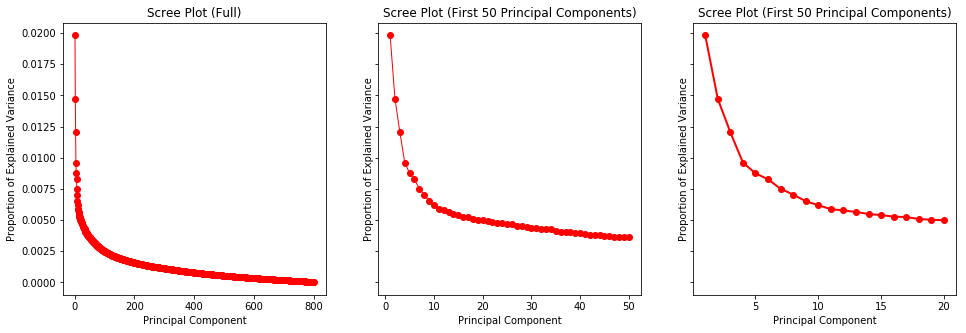

In [28]:
n = len(train_tg_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [29]:
train_tg_df['pca_reduced_10'] = train_tg_df['pca'].apply(lambda x: x[:10])

In [30]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_tg_df['pca_reduced_10'], axis=0), train_tg_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
logistic.score(np.stack(train_tg_df['pca_reduced_10'], axis=0), train_tg_df['category'])

0.625

In [32]:
print("Training:")
print(logistic.score(np.stack(train_tg_df['pca_reduced_10'], axis=0), train_tg_df['category']))

reduced_data_test = pca.transform(np.stack(test_tg_df['vect'], axis=0))
test_tg_df['pca'] = [r for r in reduced_data_test]
test_tg_df['pca_reduced_10'] = test_tg_df['pca'].apply(lambda x: x[:10])
print("Testing:")
print(logistic.score(np.stack(test_tg_df['pca_reduced_10'], axis=0), test_tg_df['category']))

Training:
0.625
Testing:
0.585


__Naive Bayes (Binomial)__

In [33]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_tg_df['vect'], axis=0), train_tg_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [34]:
print("Training:")
print(naiveBayes.score(np.stack(train_tg_df['vect'], axis=0), train_tg_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_tg_df['vect'], axis=0), test_tg_df['category']))

Training:
0.8425
Testing:
0.675


In [35]:
test_tg_df['nb_predict'] = naiveBayes.predict(np.stack(test_tg_df['vect'], axis=0))
test_tg_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_tg_df['vect'], axis=0))[:,0] #other is prop false

In [36]:
test_tg_df['nb_predict'].dtype

dtype('O')

In [37]:
print(sklearn.metrics.precision_score(test_tg_df['category'], test_tg_df['nb_predict'], pos_label='Pop'))

0.5
0.7692307692307693


In [38]:
print(sklearn.metrics.recall_score(test_tg_df['category'], test_tg_df['nb_predict'], pos_label='Pop'))

0.7692307692307693
0.5


In [40]:
print(sklearn.metrics.f1_score(test_tg_df['category'], test_tg_df['nb_predict'], pos_label='Pop'))

0.6060606060606061


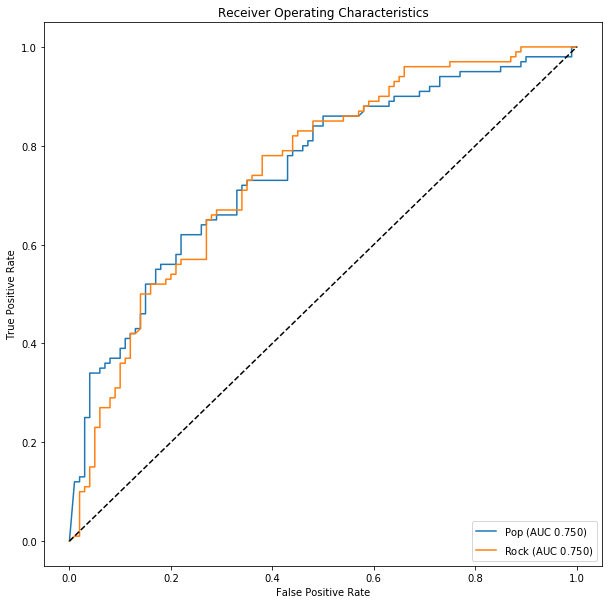

In [41]:
lucem_illud_2020.plotMultiROC(naiveBayes, test_tg_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


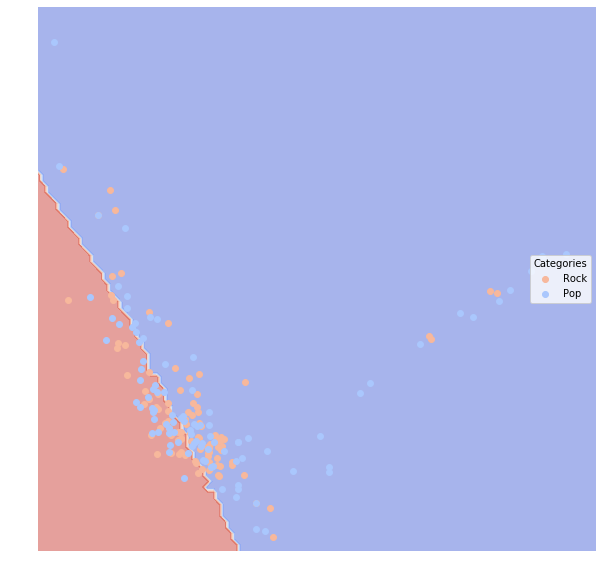

In [42]:
lucem_illud_2020.plotregions(naiveBayes, test_tg_df)

__Discussion:__ Naive Bayes classifier performs better than the logistic regression (without any regularization) since the accuracy rate on the test set for the logistic regression is higher. I think that the decision boundary for naive bayes is more flexible, hence producing a better classifer.

The region plot is clarifying. It seems that the lyrics for pop and rock music are not that different. That might be why our classifier performed very poorly.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

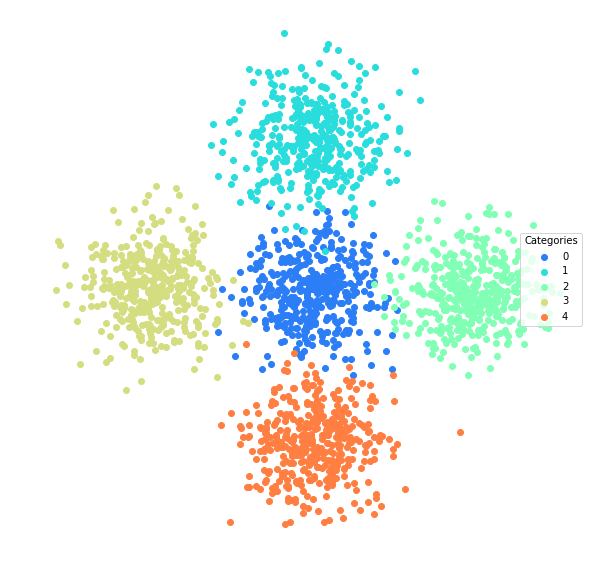

In [66]:
blobs_df = lucem_illud_2020.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud_2020.trainTestSplit(blobs_df)
lucem_illud_2020.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [67]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

To see what's going on visually with the classification: 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

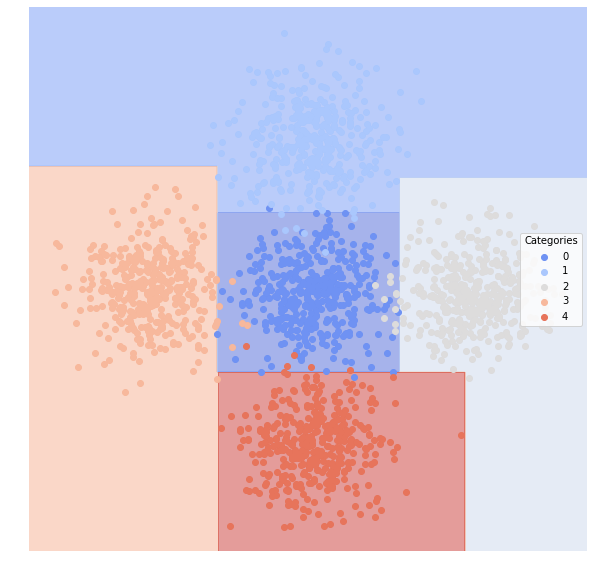

In [68]:
lucem_illud_2020.plotregions(clf_tree, df_exampleTree_train)

In [69]:
lucem_illud_2020.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.016,0.974617,0.959184,0.928033,0.959184
1,0.008,0.987593,0.980198,0.964788,0.980198
2,0.006,0.992167,0.978723,0.970199,0.989247
3,0.002,0.995536,1.000000,0.993071,0.991071
4,0.004,0.993554,0.989583,0.981275,0.989583


Lets look at accuracy:

In [70]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.982

What happens if we trim the tree?

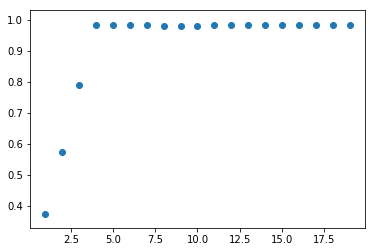

In [71]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [72]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [73]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

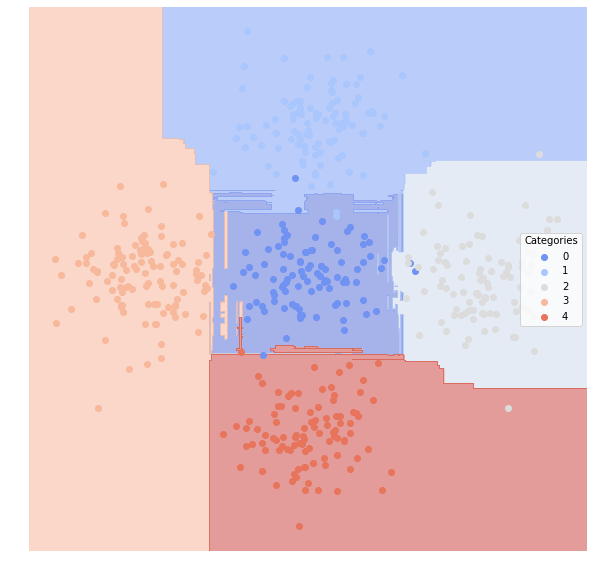

In [74]:
lucem_illud_2020.plotregions(bag, df_exampleTree_test)

In [75]:
lucem_illud_2020.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.014,0.972002,0.978947,0.939001,0.948980
1,0.010,0.986340,0.970588,0.955369,0.980198
2,0.008,0.986790,0.978495,0.961452,0.978495
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.004,0.997525,0.979592,0.979592,1.000000


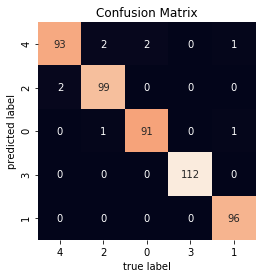

In [76]:
lucem_illud_2020.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [45]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=10,random_state=0)
clf_tree.fit(np.stack(train_tg_df['vect'], axis =0), train_tg_df['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [46]:
lucem_illud_2020.evaluateClassifier(clf_tree, test_tg_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Rock,0.435,0.565,0.556522,0.536174,0.64
Pop,0.435,0.565,0.576471,0.537471,0.49


In [47]:
sklearn.metrics.accuracy_score(test_tg_df['category'], clf_tree.predict(np.stack(test_tg_df['vect'], axis = 0)))

0.565

In [63]:
pred = clf_tree.predict(np.stack(test_tg_df['vect'], axis = 0))

In [65]:
sklearn.metrics.precision_score(test_tg_df['category'], pred, pos_label='Pop')

0.5764705882352941

In [66]:
sklearn.metrics.recall_score(test_tg_df['category'], pred, pos_label='Pop')

0.49

In [67]:
sklearn.metrics.f1_score(test_tg_df['category'], pred, pos_label='Pop')

0.5297297297297296

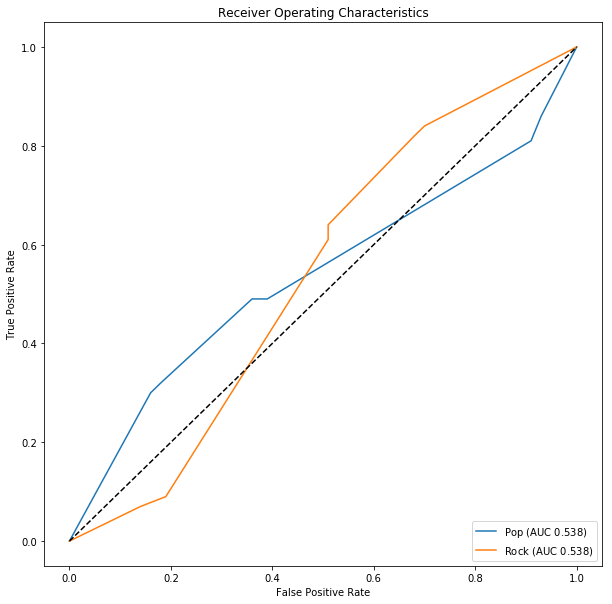

In [68]:
lucem_illud_2020.plotMultiROC(clf_tree, test_tg_df)

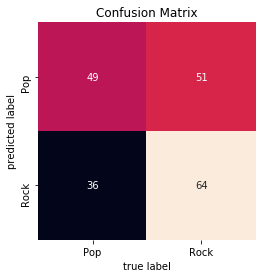

In [69]:
lucem_illud_2020.plotConfusionMatrix(clf_tree, test_tg_df)

**Random Forest**

In [70]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10)
bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)

In [71]:
bag.fit(np.stack(train_tg_df['vect'], axis =0), train_tg_df['category'])

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [72]:
lucem_illud_2020.evaluateClassifier(bag, test_tg_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Rock,0.41,0.59,0.5750,0.551750,0.69
Pop,0.41,0.59,0.6125,0.555125,0.49


In [74]:
sklearn.metrics.accuracy_score(test_tg_df['category'], bag.predict(np.stack(test_tg_df['vect'], axis = 0)))

0.59

In [77]:
pred = bag.predict(np.stack(test_tg_df['vect'], axis = 0))

In [78]:
sklearn.metrics.precision_score(test_tg_df['category'], pred, pos_label='Pop')

0.6125

In [80]:
sklearn.metrics.recall_score(test_tg_df['category'], pred, pos_label='Pop')

0.49

In [81]:
sklearn.metrics.f1_score(test_tg_df['category'], pred, pos_label='Pop')

0.5444444444444445

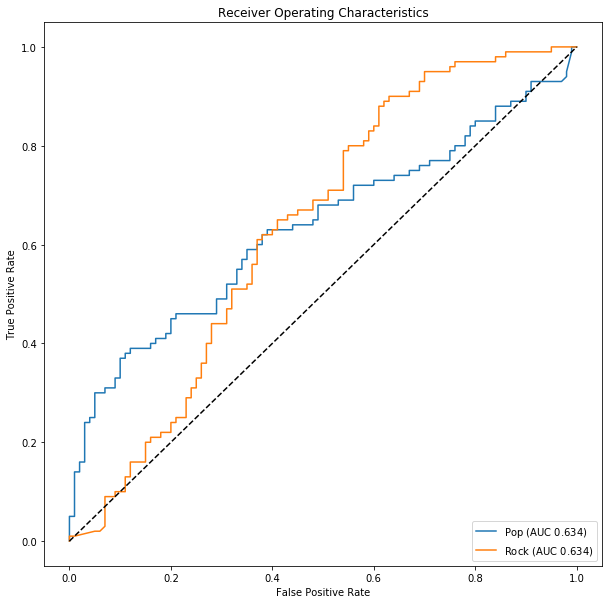

In [82]:
lucem_illud_2020.plotMultiROC(bag, test_tg_df)

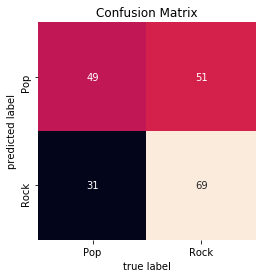

In [83]:
lucem_illud_2020.plotConfusionMatrix(bag, test_tg_df)

__Discussion:__ Ensemble classifier (random forest) performs better than the decision tree classifier because the error rate is reduced. Other metrics such as precision, recall, and F1 scores also increase.

What random forest does is to randomly sample observations, build many decision trees where an individual tree can overfit the data, then it combines the trees to produce a classifier which can perform better (and is less likely to be overfitting) than a single decision tree.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [77]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, better..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[m, sorry, read, commandment]"


Make a testing and training set:

In [78]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [79]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [80]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [81]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

In [82]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
soc.religion.christian,0.271619,0.519507,1.000000,0.310634,0.039014
sci.space,0.246082,0.715527,0.539305,0.440501,0.631692
comp.graphics,0.293674,0.715491,0.474553,0.421052,0.735608
talk.religion.misc,0.217063,0.708121,0.413953,0.316419,0.593333


And lets look at the testing data

In [83]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.27674418604651163


Let's produce another confusion matrix:

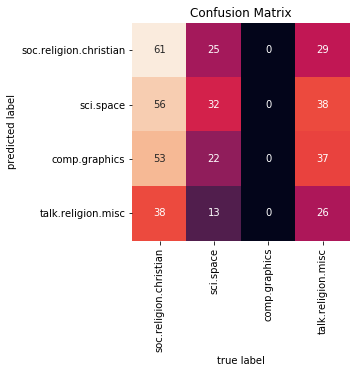

In [84]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [85]:
#lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [84]:
n_neighbors = 15
weights="uniform"
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [85]:
knn.fit(np.stack(train_tg_df['vect'], axis = 0), train_tg_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

In [86]:
lucem_illud_2020.evaluateClassifier(knn, train_tg_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Rock,0.3425,0.6575,0.744186,0.617209,0.480
Pop,0.3425,0.6575,0.616236,0.597057,0.835


In [87]:
sklearn.metrics.accuracy_score(test_tg_df['category'], knn.predict(np.stack(test_tg_df['vect'], axis = 0)))

0.56

In [88]:
pred = knn.predict(np.stack(test_tg_df['vect'], axis = 0))

In [89]:
sklearn.metrics.precision_score(test_tg_df['category'], pred, pos_label='Pop')

0.5422535211267606

In [90]:
sklearn.metrics.recall_score(test_tg_df['category'], pred, pos_label='Pop')

0.77

In [91]:
sklearn.metrics.f1_score(test_tg_df['category'], pred, pos_label='Pop')

0.6363636363636365

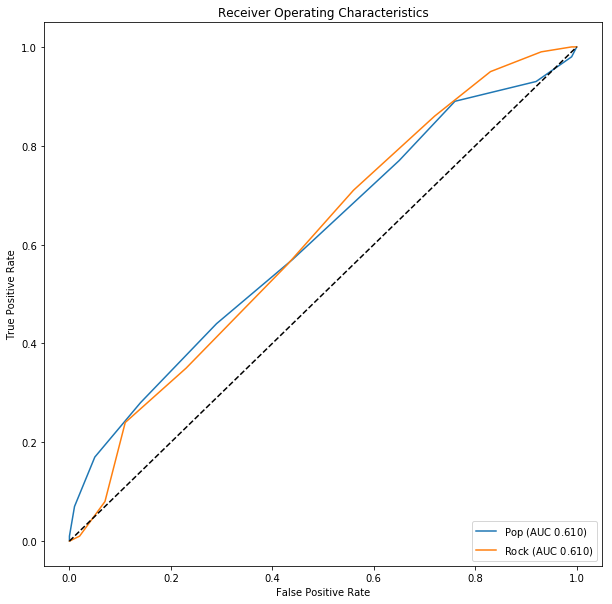

In [92]:
lucem_illud_2020.plotMultiROC(knn, test_tg_df)

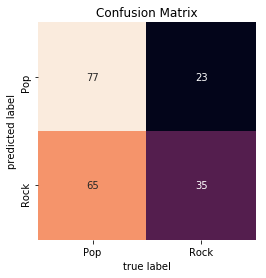

In [93]:
lucem_illud_2020.plotConfusionMatrix(knn, test_tg_df)

__Discussion:__ k-Nearest Neighbor model with 15 neighbors performs worse than the random forest classifier. However, we may be able to tune the hyperparameters such as the number of neighbors and distance measure to improve the model's accuracy.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [86]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [87]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [88]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [89]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

...and consider the results:

In [90]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.015674,0.977280,0.975000,0.948293,0.962963
Bad Roommates: Tales of Irritation,0.015674,0.980204,0.959459,0.939442,0.972603
Weeaboo Tales: stories about the extreme fans of japanese culture,0.006270,0.987805,1.000000,0.981879,0.975610
Relationships,0.025078,0.971334,0.941176,0.916562,0.963855


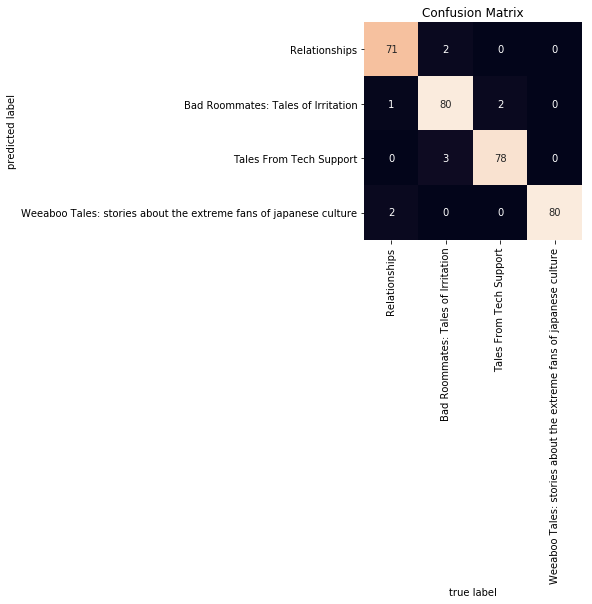

In [91]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

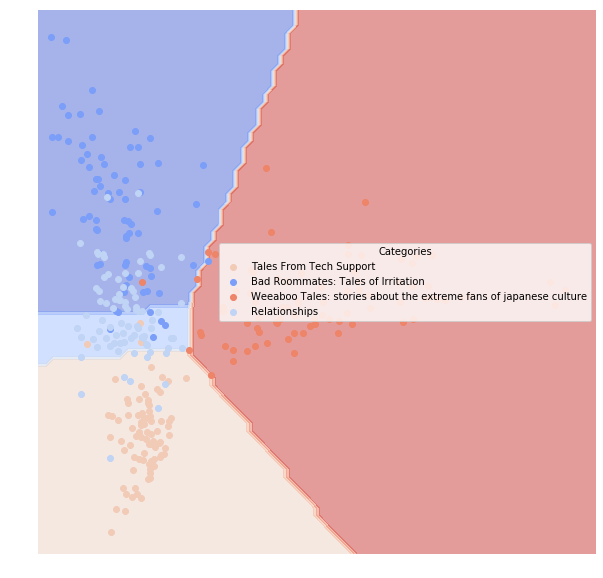

In [92]:
lucem_illud_2020.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [93]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [94]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.009404,0.989625,0.975610,0.966700,0.987654
Bad Roommates: Tales of Irritation,0.021944,0.966505,0.958333,0.918361,0.945205
Weeaboo Tales: stories about the extreme fans of japanese culture,0.006270,0.987805,1.000000,0.981879,0.975610
Relationships,0.031348,0.963192,0.929412,0.897160,0.951807


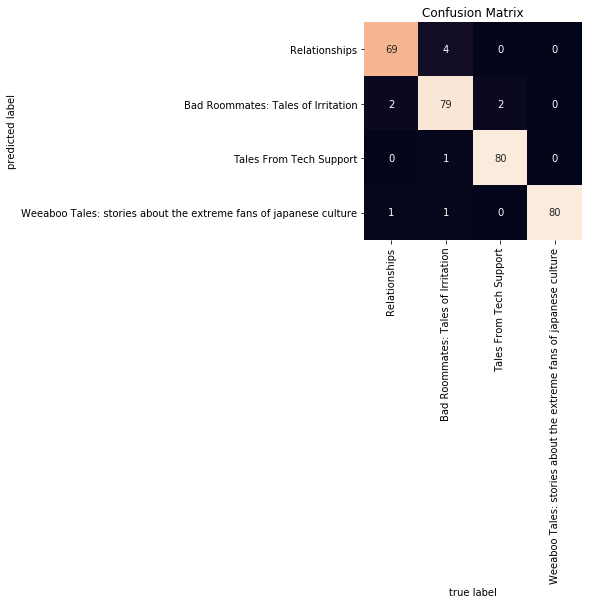

In [95]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

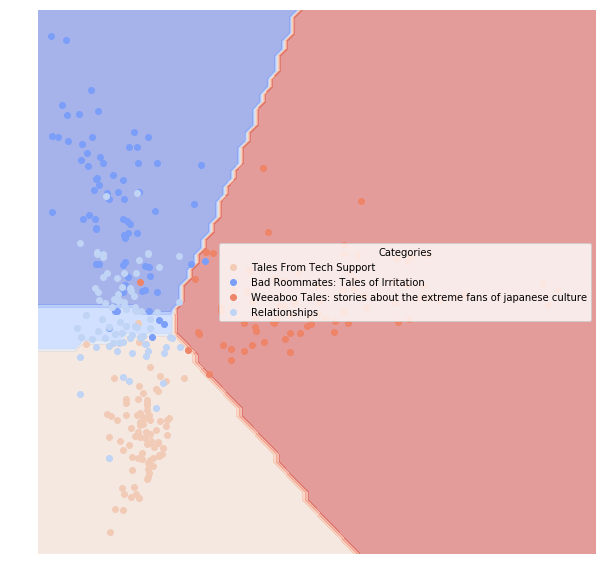

In [96]:
lucem_illud_2020.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [94]:
nn = sklearn.neural_network.MLPClassifier()
nn.fit(np.stack(train_tg_df['vect'], axis=0), train_tg_df['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [95]:
lucem_illud_2020.evaluateClassifier(nn, test_tg_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Rock,0.375,0.625,0.634409,0.579301,0.59
Pop,0.375,0.625,0.616822,0.577103,0.66


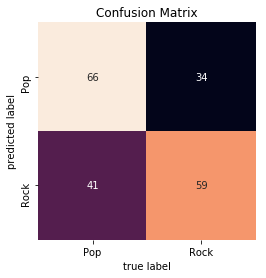

In [96]:
lucem_illud_2020.plotConfusionMatrix(nn, test_tg_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


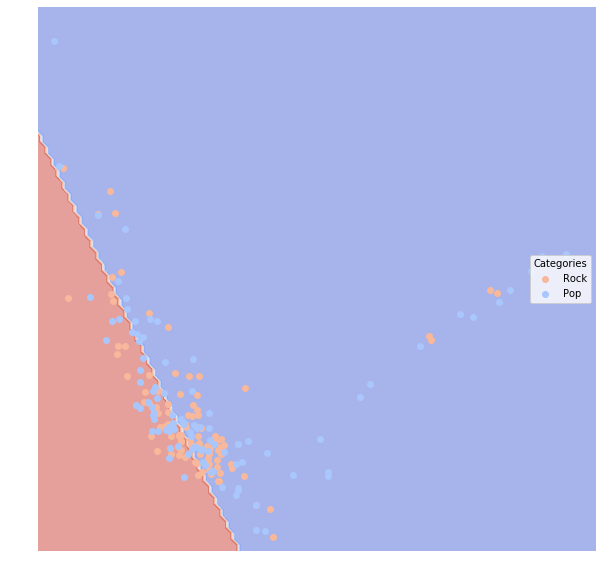

In [97]:
lucem_illud_2020.plotregions(nn, test_tg_df)

In [98]:
sklearn.metrics.accuracy_score(test_tg_df['category'], nn.predict(np.stack(test_tg_df['vect'], axis = 0)))

0.625

In [100]:
pred = nn.predict(np.stack(test_tg_df['vect'], axis = 0))

In [101]:
sklearn.metrics.precision_score(test_tg_df['category'], pred, pos_label='Pop')

0.616822429906542

In [102]:
sklearn.metrics.recall_score(test_tg_df['category'], pred, pos_label='Pop')

0.66

In [103]:
sklearn.metrics.f1_score(test_tg_df['category'], pred, pos_label='Pop')

0.6376811594202898

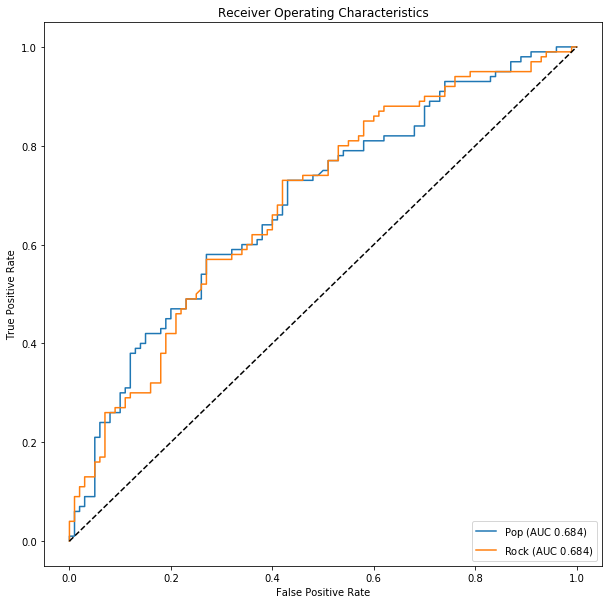

In [104]:
lucem_illud_2020.plotMultiROC(nn, test_tg_df)

__Discussion:__ a neural network classification performs a bit better than other methods we have tried so far. The accuracy rate is around 0.625 which is stilllow. However, in the future, one way to approach this classification is to tune the hyperparameters in the model such as using a different activation function.